<a href="https://colab.research.google.com/github/vutl/Sentiment-Analysis/blob/feature%2FSentiment-Analysis/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tải bộ dữ liệu

In [4]:
import pandas as pd

# Load dataset
df = pd.read_csv('./IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()

Làm sạch dữ liệu

In [5]:
!pip install contractions

In [6]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, "html.parser") # Removing html tags
    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contractions
    emoji_clean = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text) # add space after full stop
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = "".join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # lemmatize
    return text

df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-6-0b60e3540930>:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") # Removing html tags


Phân tích dữ liệu

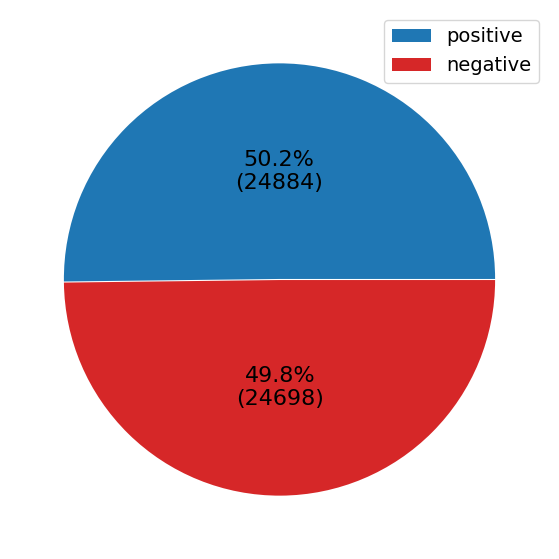

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2, pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})
plt.legend(labels, loc="best", prop={'size': 14})
plt.show()

Chia tập train và test

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(df['review'], y_data, test_size=0.2, random_state=42)

Biểu diễn văn bản thành vector

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

Huấn luyện và đánh giá mô hình

Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(x_train_encoded, y_train)

y_pred = dt_classifier.predict(x_test_encoded)
print(accuracy_score(y_pred, y_test))

0.7180598971463145


Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train)

y_pred = rf_classifier.predict(x_test_encoded)
print(accuracy_score(y_pred, y_test))

0.8420893415347384
